## PART 1

In this frst part, we want to randomly retrieve tweets posted by people during the pandemic. The way we use to retrieve tweets
aims at obtaining a sample which is the least possible biased. After retrieving data for each country ( in this first analysis
we start with Serbia and Italy, out homelands, to test the scalability and feasibility of our ideas), we want to classify them according to
the topic they present. We are interested in analysing which have been the most discussed topics to see if we get result
similar to those shown in CoronaWiki dataset. We think this is a good way to start analysing how people's interests shifted, how people reacted to the situation and how communication has been affected by COVID-19

In [163]:
# Useful libraries
import pandas as pd
import json
import re
import pickle
from datetime import datetime

# Twitter library
import tweepy

# Math libraries
import numpy as np

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob # to compute sentiment analysis on each tweet

nltk.download('stopwords')

# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ricca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### TWEETS DATASET CREATION

We start by creating lists containing the names of the analysed countries and the spoken languages.

In [85]:
# We define lists containing the names and the spoken languages in each country
# france, danimark, germany, italy, netherlands, normway, sweden, serbia, finland, england
countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI','GB']
languages = ['fr','da','de','it','nl','no','sv','sr','fi','en']
period_per_countries = {}

In order to compute our analysis, we need to define a period of time during the pandemic. We use pagelogs data in order to define this period of interest for each country. We start retrieving data from 01/12/2019 since it is reported as the official starting date from the pandemic.

In [86]:
# Importing time series
data_path = './data/'
with open(data_path+'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)

In [87]:
# Defining period of interest for each country. Dates are retrieved starting from 01/12/2019
for idx,country in enumerate(countries):
    lang = languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d')  for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (date.year >= 2020 or (date.year == 2019 and date.month == 12))]
    period_per_countries[country] = dates

We want to retrieve tweets on a daily basis. In order to reduce the bias in our data, we decide to retrieve tweets in different moments of the day which are randomly chosen. Since most of the activity was during the afternoon, we want to give more weights to these hours. 

In [88]:
# Defining a hour time window to retrieve data
hours = [11,12,13,14,15,16,17,18,19,20]
# We want to give more weights to part of the day closer to dinner / late afternoon. So we assign them a higher weights
weights = np.ones(len(hours)) / 15
weights[-5:] = weights[-5:]*2

Since we are interested in finding analogies between the topics discussed on Twittr and the pages visited on Wikipedia, we need to define a list of topics with respect to which we are going to classify each retrieved tweet. In order to do so, we use the file 'topics_linked.csv'. Considering that we use empath library to compute the classification of each text, we define a set of topics which is as equivalent as possible to the one reported in teh file.

In [89]:
provided_topics = pd.read_csv('./Data/topics_linked.csv',delimiter = ',')
provided_topics.columns

Index(['index', 'Geography.Regions.Asia.Central Asia',
       'Geography.Regions.Europe.Eastern Europe',
       'History and Society.Military and warfare', 'Culture.Media.Television',
       'History and Society.Education', 'Culture.Media.Books',
       'Geography.Regions.Africa.Africa*', 'Culture.Visual arts.Architecture',
       'Culture.Biography.Women', 'Geography.Regions.Americas.North America',
       'STEM.STEM*', 'Culture.Performing arts', 'Culture.Literature',
       'History and Society.Politics and government',
       'Geography.Regions.Africa.Northern Africa',
       'STEM.Earth and environment', 'Geography.Regions.Africa.Central Africa',
       'STEM.Medicine & Health', 'STEM.Libraries & Information',
       'Geography.Regions.Europe.Europe*',
       'Geography.Regions.Europe.Western Europe', 'Culture.Media.Radio',
       'STEM.Space', 'Culture.Visual arts.Comics and Anime', 'STEM.Technology',
       'Culture.Internet culture', 'Culture.Media.Software',
       'Geography.R

After reading the categories offered by empath library at  https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv, we report the ones we decide to use.

In [144]:
topics = ['help','medical_emergency','health','government','school','kill','art','play','computer',
         'home','business','religion','sports','death','military','music','science','fun','economics',
         'technology','philosophy','geography','tv','architecture']

topics = categories = ["money","family","health","nervousness","government",
                                                        "suffering","optimism","fear",
                                                         "death","science","scientists","sadness",
                                                         "joy","economics","politics","anger","pain",
                                                         "negative_emotion","law","achievement","contentment",
                                                         "positive_emotion", "sport", "technology", "restaurant", "travel", "school",
                                                         "grandparent", "medical_emergency", "emergency", "hospital", "flu", "pharmacy",
                                                         "pneumonia", "infection", "fever"]

We now proceed to define two helper functions that create and import the needed dataframes. As said before, we start working on tweets posted by italian and serbian people to verify the goodness of our approach. For Milestone3, we will focus on a bigger number of countries.
Notice that, in order to filter the tweets we retrieve, we set a specific query.

In [127]:
def create_dataframe(name_country,language,period_of_interest,time_window = hours, prob = weights, skip_day = 1):
    
    # Initialize the stemmer
    stemmer = PorterStemmer()
    lexicon = Empath()
    # Defining a list of topics based on Coronawiki Dataset
    topics = []
    # Defining support structure
    new_data = []
    output_path = './output/'+name_country+'_tweets.pkl'
    
    # We initialize tweepy 
    bearer_token_balsa = "AAAAAAAAAAAAAAAAAAAAAPXlYgEAAAAAmHO9bfJYAPCZSDa8%2BHELxeAfwgQ%3D91B98esE93293wEGbjH4JsUMe7R3wDok1ZCGNGLLvvQXzNcyBE"
    client = tweepy.Client(bearer_token=bearer_token_balsa, wait_on_rate_limit=True)
    
    for idx in range(0,len(period_of_interest[name_country]), skip_day):
        # We randomly choose the time of the day to retrieve tweets
        random_hour = np.random.choice(hours,p = weights)
        date = period_of_interest[name_country][idx]
        
        # We define start and end time to retrieve (then passed as inputs for twitter.API)
        start_time = datetime(date.year,date.month,date.day,random_hour)
        end_time = datetime(date.year,date.month,date.day,random_hour+2)
        
        # We define a proper wuery to get tweets from the country we're interested in
        query = " place_country:{} lang:{} -is:retweet -has:links -has:media -has:images \
                                    -has:video_link -has:mentions".format(name_country,language)
        tweets = client.search_all_tweets( query, max_results = 10, 
                                     start_time = start_time, end_time = end_time,
                                          tweet_fields  = ['text','context_annotations'])
        
        # We perform basic preprocessing operations on the text (translation and removal of punctuations)
        for tweet in tweets.data:
            if language != 'en':
                text = translator.translate(tweet.text)
            else:
                text = tweet.text
            # We remove punctuation
            text = ("".join([ch for ch in text if ch not in string.punctuation])).lower()
            # We remove numbers
            text = re.sub("\d+", "",text).strip()
            # We compute sentiment analysis on the given text
            text_sentiment = TextBlob(text).sentiment
            text_polarity, text_subjectivity = text_sentiment.polarity, text_sentiment.subjectivity
            # We tokenize the tweet to make the work easier
            tokenized_stemmed_version = nltk.word_tokenize(text)
            tokenized_stemmed_version = [stemmer.stem(word) for word in tokenized_stemmed_version]
            # Saving new datapoint in new_data list
            if len(text) > 0:
                new_data.append([date,language,text,tokenized_stemmed_version,
                             tweet.context_annotations,text_polarity,text_subjectivity])
            
        # We create the dataframe
        df = pd.DataFrame(new_data, columns = ['date','language','tweet','tokenized_tweet_list',
                                               'context_from_Twitter','polarity','subjectivity'])
        df.to_pickle(output_path)
        
        
def get_dataframe(name_country):
    get_path = './output/'+name_country+'_tweets.pkl'
    return pd.read_pickle(get_path)
        

#### TEST USING ENGLISH TWEETS. AFTER MONDAY THE ANALYSES WILL BE DONE USING ITALIAN AND SERBIAN TWEETS

In [156]:
periodo = {}
periodo['GB'] = period_per_countries['GB'][150:152]
create_dataframe('GB','en',periodo)
df = get_dataframe('GB')
df.head()

,date,language,tweet,tokenized_tweet_list,context_from_Twitter,polarity,subjectivity
0,2020-04-29,en,i know theres a lot more serious issues going ...,"[i, know, there, a, lot, more, seriou, issu, g...",[],-0.0375,0.462500
1,2020-04-29,en,zak if mum throws a wobbly i dont witness repl...,"[zak, if, mum, throw, a, wobbl, i, dont, wit, ...",[],0.0000,0.000000
2,2020-04-29,en,i have put on stone and my hair looks like sa...,"[i, have, put, on, stone, and, my, hair, look,...",[],0.0000,0.000000
3,2020-04-29,en,okay imma livestream my rehearsals for the eur...,"[okay, imma, livestream, my, rehears, for, the...",[],-0.1000,0.583333
4,2020-04-29,en,it’s out on the japanese nintendo switch store...,"[it, ’, s, out, on, the, japanes, nintendo, sw...","[{'domain': {'id': '45', 'name': 'Brand Vertic...",0.0000,0.000000


We now proceed to plot the most discussed topics based on the classification made using empath library.

Text(0.5, 0, 'Normalized Score')

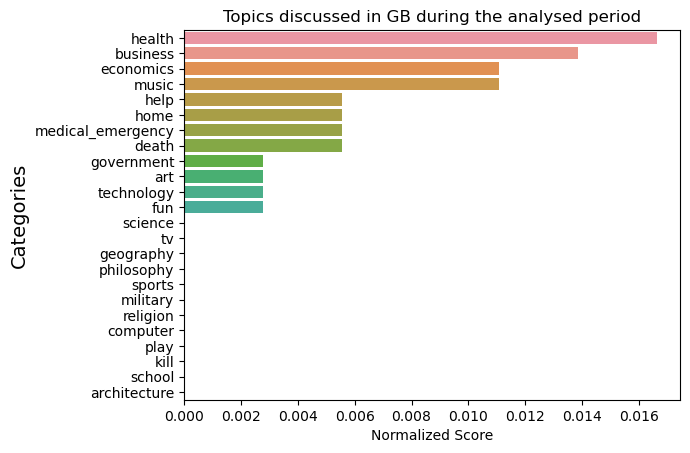

In [164]:
fig,ax = plt.subplots(1)

# We infer the topics discussed in the retrieved tweets
classified_topics = pd.DataFrame([lexicon.analyze(df.tweet.str.cat(sep = ' '),categories = topics, 
                                                  normalize = True)], index = ['EN']).T

classified_topics = classified_topics.sort_values(by = ['EN'], ascending = False)
classified_topics.reset_index(inplace = True)
sns.barplot(data = classified_topics, x = 'EN', y = 'index')
plt.ylabel('Topics', fontsize = 14)
plt.title('Topics discussed in GB during the analysed period')
plt.ylabel('Categories')
plt.xlabel('Normalized Score')
